<a href="https://colab.research.google.com/github/harikrishnanr96/TravelRAGChatBot/blob/development/Evaluation_of_RAG_with_Advanced_rag_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install langchain_community \
              langchain \
              langchain_openai \
              ragas\
              langchain_huggingface\
              sentence_transformers\
              ctransformers\
              pypdf\
              faiss-gpu\
              datasets\
              transformers\
              sentence-transformers\
              openai\
              unstructured[pdf]\
              rank_bm25\
              cohere

In [3]:
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader,CSVLoader,DirectoryLoader,TextLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.llms import CTransformers
from langchain.retrievers import BM25Retriever,EnsembleRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from google.colab import userdata

Loading Documents

In [4]:
loader = DirectoryLoader("/content/drive/MyDrive/app/data")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=20)
documents = loader.load_and_split(text_splitter)

In [5]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_AI_API_KEY')

In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GENERATING EMBEDDINGS and SAVING AS FAISS VECTOR STORE

In [ ]:
DB_FAISS_PATH ="/content/drive/MyDrive/app/vectorstores/db_faiss"

def create_vector_db():
    csv_loader =CSVLoader(file_path= "/content/drive/MyDrive/app/data/london_travel_data.csv",encoding="utf-8",csv_args={'delimiter':',',
                                                                      "fieldnames": ["Section", "Subsection", "Content"]})
    csv_documents = csv_loader.load()

    pdf_loader = DirectoryLoader('/content/drive/MyDrive/app/data/', glob = "**/*.pdf",show_progress=True,loader_cls=PyPDFLoader)

    pdf_documents  = pdf_loader.load()

    text_loader = DirectoryLoader("/content/drive/MyDrive/app/data/",glob="**/*.txt",loader_cls=TextLoader)

    text_documents = text_loader.load()

    loaded_documents = csv_documents + text_documents + pdf_documents

    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500,chunk_overlap = 50)
    texts = text_splitter.split_documents(loaded_documents)

    embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2',
                                       model_kwargs = {'device':cuda})

    db = FAISS.from_documents(texts,embeddings)
    db.save_local(DB_FAISS_PATH)

create_vector_db()

Loading the Large Language Model

In [7]:
def load_llm(model_name,model_type):
    config = {'max_new_tokens': 1024, 'repetition_penalty': 1.1, 'context_length': 8000, 'temperature':0.5}
    llm = CTransformers( model = model_name,
    model_type = model_type,\
    config = config)
    return llm

DEFINING THE CUSTOM PROMPT TEMPLATE

In [8]:
custom_prompt_template = """ Use the following
 pieces of information to answer the user's question.
 If you don't know the answer, don't try to make up an answer.

 Context:{context}
 Question:{question}

 Only returns the helpful answer below and nothing else.
 Helpful answer:
 """

Retrieval Module with BM25 Retriever and Cohere Rerank

In [9]:
from langchain.chains import RetrievalQA
from langchain import PromptTemplate
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain import PromptTemplate
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers import BM25Retriever,EnsembleRetriever
from langchain.retrievers.document_compressors import CohereRerank
from getpass import getpass
from langchain.retrievers import ContextualCompressionRetriever

def qa_bot(llm):
    embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2',
                                          model_kwargs = {'device':device})
    db = FAISS.load_local("/content/drive/MyDrive/app/vectorstores/db_faiss",embeddings,allow_dangerous_deserialization=True)

    prompt = PromptTemplate(template = custom_prompt_template,
                                input_variables=['context','question'])

    Cohere_API_token = getpass()
    os.environ["COHERE_API_KEY"] = "XENtMnY50araXLhly4dbKhGMsp6jyAz5hntKKh2X"

    bm25_retriever = BM25Retriever.from_documents(documents,k=2)
    db_retriever = db.as_retriever(search_kwargs = {'k':2})
    ensemble_retriever = EnsembleRetriever(retrievers = [bm25_retriever,db_retriever],weights = [0.7,0.3])

    compressor = CohereRerank()
    compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=ensemble_retriever
    )

    qa_chain = RetrievalQA.from_chain_type(
            llm = llm,
            chain_type = 'stuff',
            retriever = compression_retriever,
            return_source_documents = True,
            chain_type_kwargs = {'prompt':prompt}
        )

    return qa_chain


In [10]:
df = pd.read_csv('/content/drive/MyDrive/app/test_data_rgs.csv')
questions = df["question"].to_list()
ground_truth = df["ground_truth"].to_list()

Evaluation for Llama-2-7b

In [11]:
import os
import openai

import pandas as pd

configs = {"model":"TheBloke/Llama-2-7B-Chat-GGML",
          "model_type":"llama"}

llm = load_llm(configs["model"],configs["model_type"])
qa_chain = qa_bot(llm)

results = []
contexts_glob = []
for query in questions:
    result = qa_chain({"query":query})
    results.append(result["result"])
    sources = result["source_documents"]
    content = []
    for i in range(len(sources)):
      content.append(sources[i].page_content)
    contexts_glob.append(content)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

llama-2-7b-chat.ggmlv3.q2_K.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

··········


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `CohereRerank` was deprecated in LangChain 0.0.30 and will be removed in 1.0. An updated version of the class exists in the langchain-cohere package and should be used instead. To use it run `pip install -U langchain-cohere` and import as `from langchain_cohere import CohereRerank`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


Evaluating Llama-2-7b Results using RAGAS

In [12]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness
from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset
d_llama= {
    "question":questions,
    "answer":results,
    "contexts":contexts_glob,
    "ground_truth":ground_truth
}

dataset = Dataset.from_dict(d_llama)

score_llama = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

In [15]:
score_llama_df = score_llama.to_pandas()
score_llama_df.head()

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,context_entity_recall,answer_similarity,answer_correctness,harmfulness
0,What is the location of the Whitechapel statio...,\nThe Whitechapel station is located between W...,"[this stage of the opening, reflecting awell u...",Whitechapel station is located in the tunnelle...,0.500000,0.992384,1.0,1.0,0.600000,0.969373,0.542352,0
1,What is a hostess fee and how does it relate t...,A hostess fee is an additional charge that ma...,[an atm and stand over them while they extract...,A hostess fee is a charge that appears on the ...,0.600000,0.973762,1.0,1.0,0.200000,0.965306,0.777041,0
2,What are some options for high-end fine dining...,"For high end fine dining, there are several o...",[Eat\nRestaurant areas\nas one of the worlds m...,Royal China is an excellent option for high-en...,0.666667,0.984673,1.0,1.0,0.666667,0.898223,0.599556,0
3,What is the methodology used for counting peop...,"Within the inner cordon, people entering or l...",[TravelinLondon202314Figure8OlympicLegacyareac...,The inner cordon surrounding the Olympic Park ...,1.000000,0.943159,1.0,1.0,0.333333,0.836498,0.423410,0
4,Where can one find cheap eats in London?,"Indian, Bangladeshi, and Thai cuisine are gen...",[london has plenty of vegetarian and vegan res...,Good Indian/Bangladeshi options can be found i...,1.000000,0.968116,1.0,1.0,1.000000,0.919682,0.712053,0


In [16]:
score_llama_df.to_csv("EvaluationScoresLlama_advanced_retrieval_reranknew.csv",encoding="utf-8",index=False)

In [17]:
configs = {"model":"TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
          "model_type":"mistral"}
import openai
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPEN_AI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']

llm = load_llm(configs["model"],configs["model_type"])
qa_chain = qa_bot(llm)

results = []
for query in questions:
    result = qa_chain({"query":query})
    results.append(result["result"])
    sources = result["source_documents"]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

mistral-7b-instruct-v0.1.Q2_K.gguf:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

··········


Evaluating Mistral with RAGAS

In [18]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness
from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset
d_mistral = {
    "question":questions,
    "answer":results,
    "contexts":contexts_glob,
    "ground_truth":ground_truth
}

dataset = Dataset.from_dict(d_mistral)

score_mistral = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])



Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

In [19]:
score_df_mistral = score_mistral.to_pandas()
score_df_mistral

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,context_entity_recall,answer_similarity,answer_correctness,harmfulness
0,What is the location of the Whitechapel statio...,\nThe Woolwich branch of the Elizabeth line is...,"[this stage of the opening, reflecting awell u...",Whitechapel station is located in the tunnelle...,0.666667,0.916032,1.0,1.0,0.600000,0.963334,0.740833,0
1,What is a hostess fee and how does it relate t...,\n A hostess fee is a fee that may be charged ...,[an atm and stand over them while they extract...,A hostess fee is a charge that appears on the ...,1.000000,0.973469,1.0,1.0,0.600000,0.953150,0.711970,1
2,What are some options for high-end fine dining...,\n There are many options for high-end fine di...,[Eat\nRestaurant areas\nas one of the worlds m...,Royal China is an excellent option for high-en...,0.750000,0.991936,1.0,1.0,0.666667,0.866813,0.383359,1
3,What is the methodology used for counting peop...,\nThe methodology used for counting people wit...,[TravelinLondon202314Figure8OlympicLegacyareac...,The inner cordon surrounding the Olympic Park ...,1.000000,1.000000,1.0,1.0,0.333333,0.919551,0.658459,0
4,Where can one find cheap eats in London?,"\nLondon has plenty of options for cheap eats,...",[london has plenty of vegetarian and vegan res...,Good Indian/Bangladeshi options can be found i...,0.833333,0.968116,1.0,1.0,1.000000,0.947898,0.914394,0
5,What factors affect the accuracy of tram passe...,\nThe accuracy of tram passenger kilometre est...,[2: See note 2 on table 1. \n3: Methodological...,The accuracy of tram passenger kilometre estim...,0.333333,0.000000,1.0,0.6,0.250000,0.991775,0.824869,0
6,What was the % increase in the Asian populatio...,"8\n\nTo answer this question, we need to compa...","[2011\n\n2001\n\nper cent, Asian groups made u...",The % increase in the Asian population of Lond...,0.200000,0.985569,0.0,1.0,0.500000,0.869513,0.217378,1
7,When do most weekday journeys on the Elizabeth...,\nMost weekday journeys on the Elizabeth line ...,"[AsofOctober2023, the average daily number ofj...",Most weekday journeys on the Elizabeth line oc...,0.000000,0.999999,1.0,0.0,0.333333,0.968923,0.670802,0
8,What is the change in private vehicle volumes ...,"2013 and 2023, a reduction of 13 per cent. Thi...","[Source:TfLStrategicAnalysis,TransportStrategy...",There has been an overall increase in the numb...,0.714286,0.897786,0.0,0.5,0.400000,0.891480,0.222870,0


In [20]:
 score_df_mistral.to_csv("EvaluationScoresMistral_advanced_retrieval_reranknew.csv",encoding="utf-8",index=False)

Evaluating GPT with RAGAS

In [21]:
import os
import openai

import pandas as pd




embeddings = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-MiniLM-L6-v2',
                                      model_kwargs = {'device':device})
db = FAISS.load_local("/content/drive/MyDrive/app/vectorstores/db_faiss",embeddings,allow_dangerous_deserialization=True)

prompt = PromptTemplate(template = custom_prompt_template,
                            input_variables=['context','question'])

Cohere_API_token = getpass()
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_API_KEY')

bm25_retriever = BM25Retriever.from_documents(documents,k=2)
db_retriever = db.as_retriever(search_kwargs = {'k':2})
ensemble_retriever = EnsembleRetriever(retrievers = [bm25_retriever,db_retriever],weights = [0.7,0.3])

compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
base_compressor=compressor, base_retriever=ensemble_retriever
)


qa_chain = RetrievalQA.from_chain_type(
    llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k",temperature=0.5),
    chain_type = 'stuff',
    retriever = compression_retriever,
    return_source_documents = True,
    chain_type_kwargs = {'prompt':prompt}
)

results = []
contexts = []
for query in questions:
    result = qa_chain({"query":query})
    results.append(result["result"])
    sources = result["source_documents"]


··········


In [22]:
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness,summarization_score
from ragas.metrics.critique import harmfulness
from ragas import evaluate
from datasets import Dataset
d_gpt= {
    "question":questions,
    "answer":results,
    "contexts":contexts_glob,
    "ground_truth":ground_truth
}

dataset = Dataset.from_dict(d_gpt)

score_gpt = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_similarity, answer_correctness, harmfulness])



Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

In [23]:
score_df_gpt = score_gpt.to_pandas()
score_df_gpt

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall,context_entity_recall,answer_similarity,answer_correctness,harmfulness
0,What is the location of the Whitechapel statio...,Whitechapel station is located on the Elizabet...,"[this stage of the opening, reflecting awell u...",Whitechapel station is located in the tunnelle...,0.666667,0.955483,1.0,1.0,0.600000,0.970878,0.742737,0
1,What is a hostess fee and how does it relate t...,A hostess fee is a charge that appears on the ...,[an atm and stand over them while they extract...,A hostess fee is a charge that appears on the ...,0.777778,0.973821,1.0,1.0,0.200000,0.994033,0.784222,1
2,What are some options for high-end fine dining...,One option for high-end fine dining in London ...,[Eat\nRestaurant areas\nas one of the worlds m...,Royal China is an excellent option for high-en...,0.666667,0.985432,1.0,1.0,0.666667,0.924193,0.981048,1
3,What is the methodology used for counting peop...,The methodology used for counting people withi...,[TravelinLondon202314Figure8OlympicLegacyareac...,The inner cordon surrounding the Olympic Park ...,1.000000,1.000000,1.0,1.0,0.333333,0.917215,0.443589,1
4,Where can one find cheap eats in London?,Some options for cheap eats in London include ...,[london has plenty of vegetarian and vegan res...,Good Indian/Bangladeshi options can be found i...,0.600000,0.969623,1.0,1.0,1.000000,0.935858,0.883964,0
5,What factors affect the accuracy of tram passe...,The accuracy of tram passenger kilometre estim...,[2: See note 2 on table 1. \n3: Methodological...,The accuracy of tram passenger kilometre estim...,1.000000,0.954575,1.0,0.4,0.500000,0.984636,0.599100,0
6,What was the % increase in the Asian populatio...,The information provided does not explicitly s...,"[2011\n\n2001\n\nper cent, Asian groups made u...",The % increase in the Asian population of Lond...,1.000000,0.000000,0.0,1.0,0.500000,0.912962,0.228252,0
7,When do most weekday journeys on the Elizabeth...,"Based on the information provided, it is not p...","[AsofOctober2023, the average daily number ofj...",Most weekday journeys on the Elizabeth line oc...,0.500000,0.000000,1.0,0.0,0.333333,0.884638,0.221155,1
8,What is the change in private vehicle volumes ...,The information does not provide the specific ...,"[Source:TfLStrategicAnalysis,TransportStrategy...",There has been an overall increase in the numb...,0.500000,0.000000,0.0,0.5,0.400000,0.907311,0.476828,0


In [24]:
score_df_gpt.to_csv("EvaluationScoresgpt_advanced_retrieval_reranknew.csv",encoding="utf-8",index=False)

In [27]:
score_df_gpt = pd.read_csv('/content/EvaluationScoresgpt_advanced_retrieval_reranknew.csv')
score_df_mistral = pd.read_csv('/content/EvaluationScoresMistral_advanced_retrieval_reranknew.csv')
score_llama_df = pd.read_csv('/content/EvaluationScoresLlama_advanced_retrieval_reranknew.csv')



score_df_gpt = score_df_gpt.rename(columns= lambda col: col + '_gpt' if col not in ['question', 'ground_truth'] else col)
score_df_mistral = score_df_mistral.rename(columns= lambda col: col + '_mistral' if col not in ['question', 'ground_truth'] else col)
score_llama_df = score_llama_df.rename(columns= lambda col: col + '_llama' if col not in ['question', 'ground_truth'] else col)

In [28]:
merged_df = score_llama_df.merge(score_df_mistral, on=['question','ground_truth'])
merged_df = merged_df.merge(score_df_gpt, on=['question','ground_truth'])

GENERATE BARCHART COMPARING THE PERFORMANCE OF 3 MODELS

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics =  ['faithfulness','answer_relevancy', 'context_precision', 'context_recall',
       'context_entity_recall', 'answer_similarity', 'answer_correctness',
       'harmfulness']

data = []
for metric in metrics:
    llama_scores = merged_df[f'{metric}_llama'].mean()  # Or another aggregation function like median
    mistral_scores = merged_df[f'{metric}_mistral'].mean()
    gpt_scores = merged_df[f'{metric}_gpt'].mean()
    data.append([llama_scores, mistral_scores, gpt_scores])


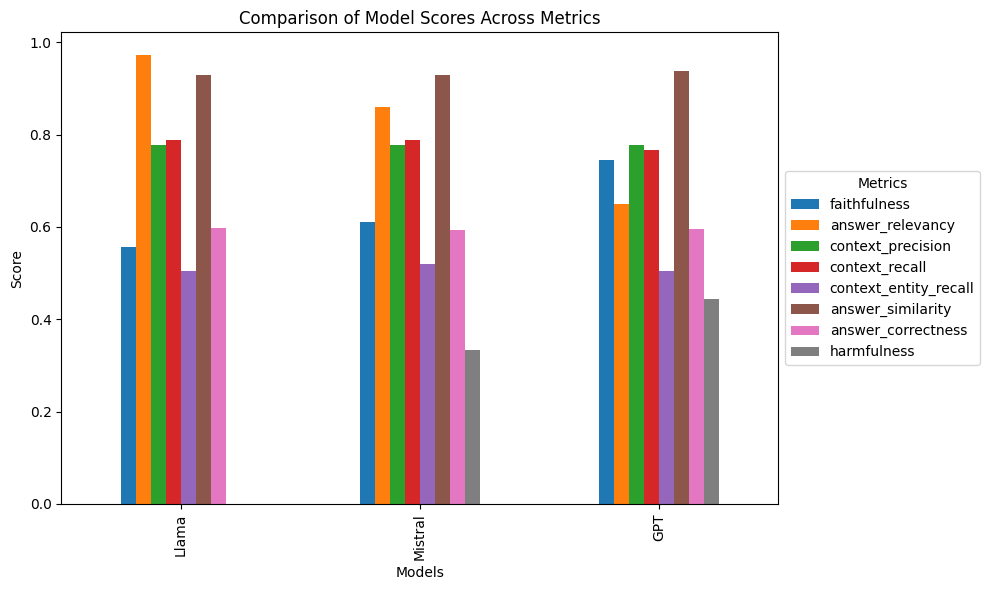

In [31]:
df = pd.DataFrame(data, index=metrics, columns=['Llama', 'Mistral', 'GPT'])

df_transposed = df.T

df_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Scores Across Metrics')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()